In [1]:
!pip install -U albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

In [1]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [64]:
# Configuration
CSV_FILE = "./object-localization-dataset/train.csv"
DATA_DIR = "./object-localization-dataset/"

DEVICE = "cuda"
BATCH_SIZE = 16
IMAGE_SIZE = 140

LR = 0.001
EPOCHS = 100
MODEL_NAME = "efficientnet_b0"
NUM_CORD = 4

In [3]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


## Understand the dataset

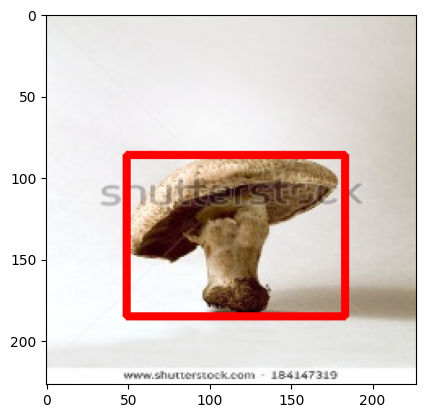

In [4]:
row = df.iloc[2]
image = cv2.imread(DATA_DIR + row.img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
point1 = (row.xmin, row.ymin)
point2 = (row.xmax, row.ymax)
bounding_box_image = cv2.rectangle(image, point1, point2, (255,0,0), 3)
plt.imshow(bounding_box_image)

In [5]:
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=44)

## Augmentations

In [6]:
import albumentations as A

/home/shaonsani/anaconda3/envs/tf_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/shaonsani/anaconda3/envs/tf_gpu/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [7]:
train_augs = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE), 
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]))

validation_augs = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE), 
], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]))


## Custom DataSet

In [8]:
class ObjectLocalDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentations = None):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        xmin, ymin, xmax, ymax = row.xmin, row.ymin, row.xmax, row.ymax
        bbox = [[xmin, ymin, xmax, ymax]]

        image_path = DATA_DIR + row.img_path
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.augmentations:
            data = self.augmentations(image=image, bboxes=bbox, class_labels=[None])
            image = data["image"]
            bbox = data["bboxes"][0]
            

        image = torch.from_numpy(image).permute(2,0,1)
        bbox = torch.Tensor(bbox)
        return image, bbox
        


In [9]:
trainset = ObjectLocalDataset(train_df, train_augs)
validationset = ObjectLocalDataset(validation_df, validation_augs)

In [10]:
print(f"Total number of training set: {len(trainset)}")
print(f"Total number of validation set: {len(validationset)}")

Total number of training set: 148
Total number of validation set: 38


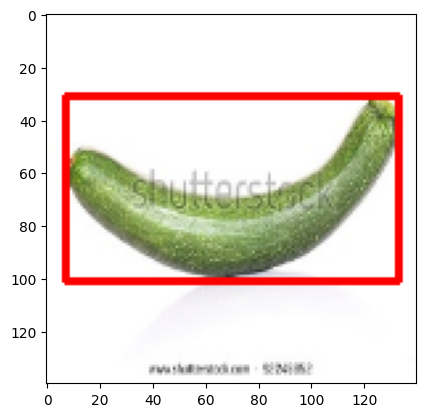

In [11]:
img, bbox = trainset[0]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

In [12]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validationloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [14]:
for images, bboxes in trainloader:
    break
print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


## Model

In [15]:
from torch import nn
import timm

In [55]:
class ObjectLocalizeModel(nn.Module):
    def __init__(self):
        super(ObjectLocalizeModel, self).__init__()
        self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4)

    def forward(self, images, gt_bboxes=None):
        images = images.float()
        bboxes = self.backbone(images)
        if gt_bboxes !=None:
            gt_bboxes = gt_bboxes.float()
            loss = nn.MSELoss()(bboxes, gt_bboxes)
            return bboxes, loss
        return bboxes
            

In [56]:
model = ObjectLocalizeModel()
model.to(DEVICE)

ObjectLocalizeModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kerne

## Checking with random image

In [57]:
random_image = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_image).shape

torch.Size([1, 4])

## Create training and Eval Function

In [58]:
def training_fn(model, dataloader, optimizer):
    total_loss = 0.0
    model.train()
    for data in dataloader:
        images, gt_bboxes = data
        images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
        bboxes, loss = model(images, gt_bboxes)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss +=loss.item()

    return total_loss/len(dataloader)
                                                    
        

In [62]:
def validation_fn(model, dataloader):
    total_loss = 0.0
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            images, gt_bboxes = data
            images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
            bboxes, loss = model(images, gt_bboxes)
            total_loss +=loss.item()

    return total_loss/len(dataloader)
                                                    
        

## Training Loop

In [60]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [68]:
best_validation_loss = np.inf
for i in range(EPOCHS):
    train_loss = training_fn(model, trainloader, optimizer)
    validation_loss = validation_fn(model, validationloader)

    if validation_loss < best_validation_loss:
        torch.save(model.state_dict(), "best_model.pt")
        best_validation_loss = validation_loss
    print(f"Epochs: {i+1}, training loss: {train_loss}, validation loss: {validation_loss}")

Epochs: 1, training loss: 561.5434936523437, validation loss: 112.87097422281902
Epochs: 2, training loss: 545.7273681640625, validation loss: 116.74997456868489
Epochs: 3, training loss: 663.0089172363281, validation loss: 144.90337880452475
Epochs: 4, training loss: 568.4499252319335, validation loss: 107.05810928344727
Epochs: 5, training loss: 545.4958435058594, validation loss: 266.3802897135417
Epochs: 6, training loss: 608.4857009887695, validation loss: 122.65074666341145
Epochs: 7, training loss: 458.99843444824216, validation loss: 116.84256490071614
Epochs: 8, training loss: 604.5155487060547, validation loss: 209.16260782877603
Epochs: 9, training loss: 445.0628143310547, validation loss: 175.39803822835287
Epochs: 10, training loss: 691.3484130859375, validation loss: 169.5077133178711
Epochs: 11, training loss: 534.1180923461914, validation loss: 195.6064707438151
Epochs: 12, training loss: 701.610806274414, validation loss: 191.05853271484375
Epochs: 13, training loss: 5

## Inference

In [70]:
import utils

/tmp/ipykernel_46031/276819008.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


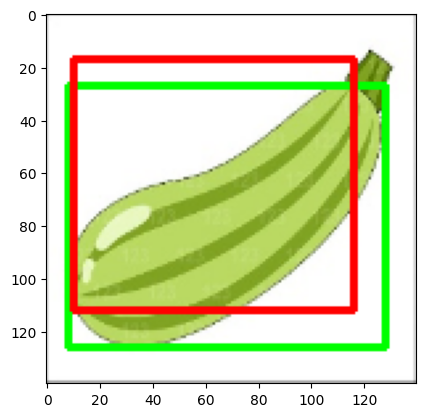

In [76]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

with torch.no_grad():
    image, gt_bboxes = validationset[1]
    image = image.unsqueeze(0).to(DEVICE)
    predicted_bbox = model(image.float())
    utils.compare_plots(image, gt_bboxes.float(), predicted_bbox)